In [4]:
using ProgressMeter, PyCall, PyPlot, Images, HDF5,NaNStatistics, Statistics
using _Data

┌ Warning: You are using a non-official build of Julia. This may cause issues with CUDA.jl.
│ Please consider using an official build from https://julialang.org/downloads/.
└ @ CUDA ~/.julia/packages/CUDA/75aiI/src/initialization.jl:180


In [5]:
@pyimport scipy.ndimage as ndimage
@pyimport numpy as np

In [6]:
img_bg_original = h5open("../data/chuyu_chamber.h5", "r") do file
    read(file, "image")
end;

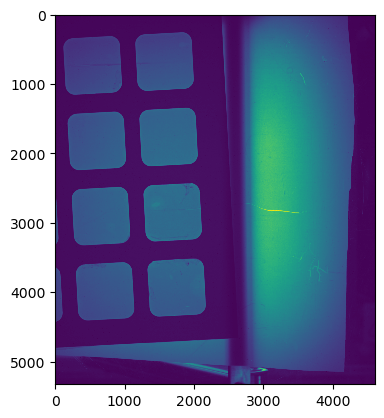

PyObject <matplotlib.image.AxesImage object at 0x7f5a3ec95310>

In [7]:
imshow(img_bg_original)

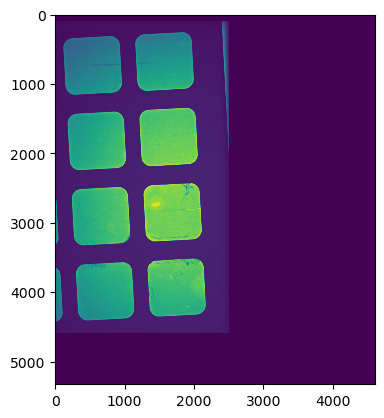

PyObject <matplotlib.image.AxesImage object at 0x7f5a3e8c4910>

In [8]:
img_bg_end = zeros(size(img_bg_original))


img_bg_end[100:4600, 1:2500] = img_bg_original[100:4600, 1:2500]
imshow(img_bg_end)

In [9]:
function solve_geometry(x_fish, y_fish, C, img_bg;method="trajectory",background_threshold_low=0,background_threshold_high=250)
    if method == "trajectory"
        xy_projection = zeros(size(img_bg[:,:,end])); 

        for i = findall(C.>0.4)
        # for i = 1:length(x_fish)

            x = round.(Int64, x_fish[i])
            y = round.(Int64, y_fish[i])
            xy_projection[x, y] = 1;
        end

        σ = 3.0f0
        kern_σ = KernelFactors.gaussian((σ, σ))
        img_xy = imfilter(xy_projection, kern_σ);
        img_xy = (img_xy.>0);
    else
        img_bg_end = img_bg[:,:,end];
        l = size(img_bg_end)[1]
        w = size(img_bg_end)[2]


        figure()
        img_hist(img_bg_end, th_l=0, th_h=500, bins=200);


        #assumption 1: chamber size larger than 100000
        #assumption 2: no attachment to the edge
        #assumption 3: center closest the image center


        minimim_component_size = 10000

        img_xy = (img_bg_end .< background_threshold_high) .* (img_bg_end .> background_threshold_low); 
        img_xy .= erode(img_xy);
    end
    figure()
    imshow(img_xy)
    img_label = label_components(img_xy);
    img_bg_label_area = component_lengths(img_label)
    # candidate_roi_idx = (findall(img_bg_label_area .> 100000).-1); #julia1.7
    candidate_roi_idx = (findall(img_bg_label_area .> 100000));
    edge_covering = zeros(length(candidate_roi_idx))
    for (index, i) in enumerate(candidate_roi_idx)
        roi = (img_label .== i)
        edge_covering[index] = sum(roi[1,:])+sum(roi[end,:])+sum(roi[:,1])+sum(roi[:,end])
    end
    roi_idx = candidate_roi_idx[edge_covering.==minimum(edge_covering)];
    
    println(roi_idx)

    chamber_roi = (img_label .== roi_idx);

    for i = 1:3
        chamber_roi .= dilate(closing(chamber_roi))
        # fig, ax = PyPlot.subplots(1,1)
        # ax.imshow(chamber_roi)
    end
    

    #find countour and center
    countour = find_contours(chamber_roi)[1];
    countour_array = hcat(getindex.(countour, 1), getindex.(countour,2));
    center_loc = mean(countour_array, dims=1);
    BoolBorder = zeros(Int64, size(chamber_roi));
    for ind in countour
        BoolBorder[ind] = 1
    end

    chamber_roi = convert(Array{Int64}, chamber_roi);
    
    chamber_roi = ndimage.binary_fill_holes(BoolBorder)
    chamber_roi = convert(Array{Int64}, chamber_roi)
    
    figure()
    imshow(chamber_roi')
    scatter(center_loc[1], center_loc[2], color="r", s=10)
    
    chamber_roi_xy = findall(chamber_roi.!=0)
    chamber_roi_x = [xy[1] for xy in chamber_roi_xy][1:1000:end]
    chamber_roi_y = [xy[2] for xy in chamber_roi_xy][1:1000:end];
    return countour_array, center_loc,chamber_roi, chamber_roi_x, chamber_roi_y
end


solve_geometry (generic function with 1 method)

In [10]:

"""
Functions for detecting the edges
"""
function find_contours(image)
    nbd = 1
    lnbd = 1
    image = Float64.(image)
    contour_list =  Vector{typeof(CartesianIndex[])}()
    done = [false, false, false, false, false, false, false, false]

    # Clockwise Moore neighborhood.
    dir_delta = [CartesianIndex(-1, 0) , CartesianIndex(-1, 1), CartesianIndex(0, 1), CartesianIndex(1, 1), CartesianIndex(1, 0), CartesianIndex(1, -1), CartesianIndex(0, -1), CartesianIndex(-1,-1)]

    height, width = size(image)

    for i=1:height
        lnbd = 1
        for j=1:width
            fji = image[i, j]
            is_outer = (image[i, j] == 1 && (j == 1 || image[i, j-1] == 0)) ## 1 (a)
            is_hole = (image[i, j] >= 1 && (j == width || image[i, j+1] == 0))

            if is_outer || is_hole
                # 2
                border = CartesianIndex[]

                from = CartesianIndex(i, j)

                if is_outer
                    nbd += 1
                    from -= CartesianIndex(0, 1)

                else
                    nbd += 1
                    if fji > 1
                        lnbd = fji
                    end
                    from += CartesianIndex(0, 1)
                end

                p0 = CartesianIndex(i,j)
                detect_move(image, p0, from, nbd, border, done, dir_delta) ## 3
                if isempty(border) ##TODO
                    push!(border, p0)
                    image[p0] = -nbd
                end
                push!(contour_list, border)
            end
            if fji != 0 && fji != 1
                lnbd = abs(fji)
            end

        end
    end

    return contour_list
end

function detect_move(image, p0, p2, nbd, border, done, dir_delta)
    dir = from_to(p0, p2, dir_delta)
    moved = clockwise(dir)
    p1 = CartesianIndex(0, 0)
    while moved != dir ## 3.1
        newp = move(p0, image, moved, dir_delta)
        if newp[1]!=0
            p1 = newp
            break
        end
        moved = clockwise(moved)
    end

    if p1 == CartesianIndex(0, 0)
        return
    end

    p2 = p1 ## 3.2
    p3 = p0 ## 3.2
    done .= false
    while true
        dir = from_to(p3, p2, dir_delta)
        moved = counterclockwise(dir)
        p4 = CartesianIndex(0, 0)
        done .= false
        while true ## 3.3
            p4 = move(p3, image, moved, dir_delta)
            if p4[1] != 0
                break
            end
            done[moved] = true
            moved = counterclockwise(moved)
        end
        push!(border, p3) ## 3.4
        if p3[1] == size(image, 1) || done[3]
            image[p3] = -nbd
        elseif image[p3] == 1
            image[p3] = nbd
        end

        if (p4 == p0 && p3 == p1) ## 3.5
            break
        end
        p2 = p3
        p3 = p4
    end
end

function clockwise(dir)
    return (dir)%8 + 1
end

# rotate direction counterclocwise
function counterclockwise(dir)
    return (dir+6)%8 + 1
end

# move from current pixel to next in given direction
function move(pixel, image, dir, dir_delta)
    newp = pixel + dir_delta[dir]
    height, width = size(image)
    if (0 < newp[1] <= height) &&  (0 < newp[2] <= width)
        if image[newp]!=0
            return newp
        end
    end
    return CartesianIndex(0, 0)
end

# finds direction between two given pixels
function from_to(from, to, dir_delta)
    delta = to-from
    return findall(x->x == delta, dir_delta)[1]
end


from_to (generic function with 1 method)

In [11]:

function img_hist(img;  th_l=nothing, th_h=nothing, bins=200)
    img_reshape = reshape(img,size(img,1)*size(img,2));
    if isnothing(th_l)
        th_l = minimum(img_reshape)
    end
    if isnothing(th_h)
        th_h = maximum(img_reshape)
    end  
    img_reshape = img_reshape[findall(img_reshape.<th_h)];
    img_reshape = img_reshape[findall(img_reshape.>th_l)];
    PyPlot.hist(img_reshape,bins);
end

img_hist (generic function with 1 method)

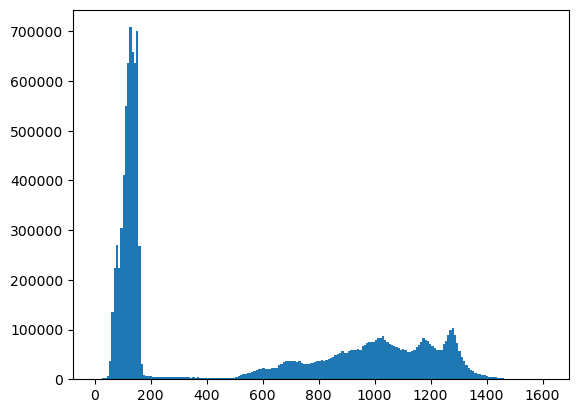

In [13]:
l = size(img_bg_end)[1]
w = size(img_bg_end)[2]


figure()
img_hist(img_bg_end, bins=200);


background_threshold_high = 1600 #may need to play with these two parameters
background_threshold_low = 500


img_xy = (img_bg_end .< background_threshold_high) .* (img_bg_end .> background_threshold_low); 
img_xy .= erode(img_xy);

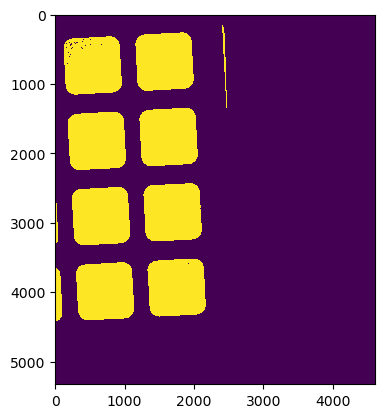

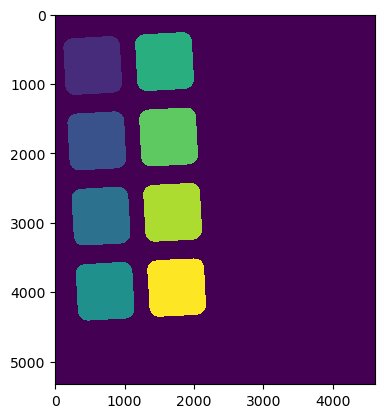

In [14]:
roi_idx = 1


figure()
imshow(img_xy)
img_label = label_components(img_xy);
img_bg_label_area = component_lengths(img_label)
candidate_roi_idx = intersect(findall(img_bg_label_area .> 600000), findall(img_bg_label_area .< 800000));

chamber_roi_all = zeros(size(img_xy)); 
for roi_idx = candidate_roi_idx
    chamber_roi = (img_label .== roi_idx);
    chamber_roi_all += chamber_roi;
end

for i = 1:3
    chamber_roi_all .= dilate(closing(chamber_roi_all))
end

img_label = label_components(chamber_roi_all);

figure()
imshow(img_label)

img_bg_label_area = component_lengths(img_label)
candidate_roi_idx = intersect(findall(img_bg_label_area .> 600000), findall(img_bg_label_area .< 800000));

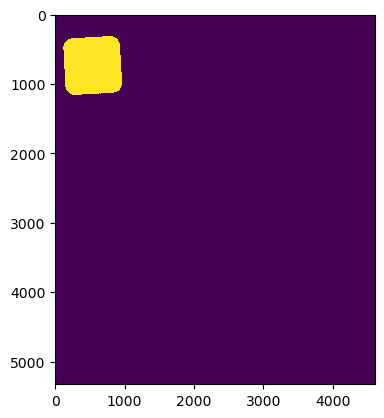

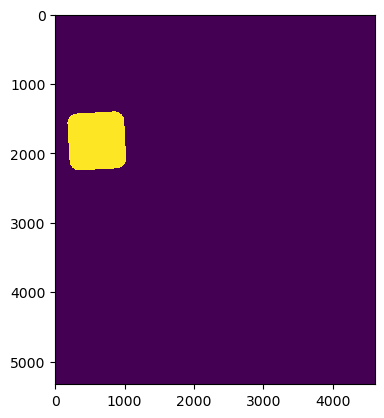

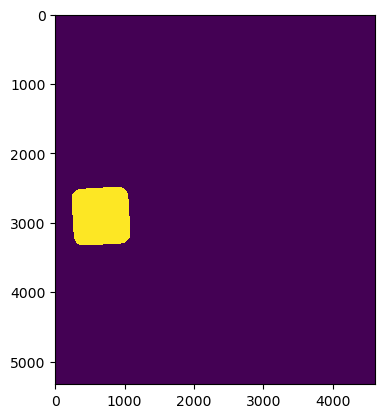

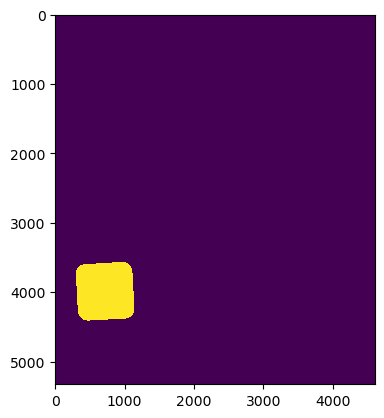

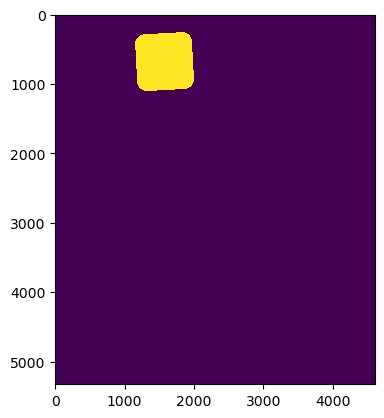

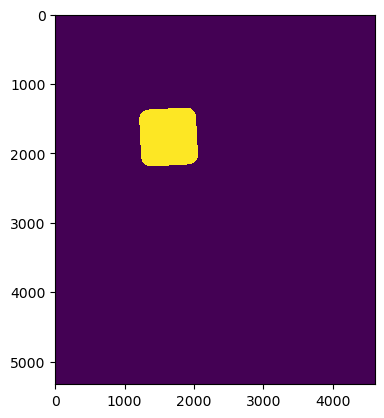

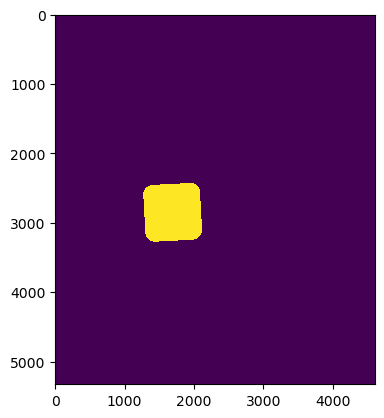

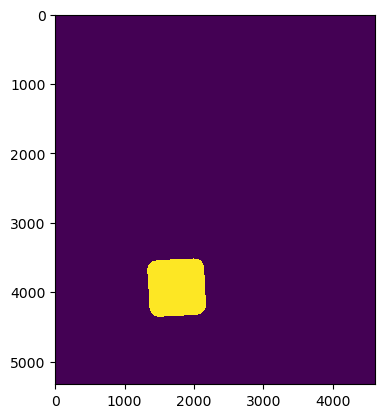

In [15]:
chamber_roi_all = BitArray(undef, size(chamber_roi_all, 1), size(chamber_roi_all, 2), length(candidate_roi_idx))
countour_array_all = fill(NaN32)
for (which_roi, roi_idx) in enumerate(candidate_roi_idx)
    chamber_roi = (img_label .== roi_idx);


    countour = find_contours(chamber_roi)[1];
    countour_array = hcat(getindex.(countour, 1), getindex.(countour,2));

    
    fig, ax = PyPlot.subplots(1,1)
    ax.imshow(chamber_roi)
    chamber_roi_all[:, :, which_roi] .= chamber_roi
end

In [19]:
h5open(joinpath("../data/chuyu_chamber.h5"), "r+") do file
    exists = haskey(file, "chamber_roi_all")
    if exists
        delete_object(file, "chamber_roi_all")
    end
    file["chamber_roi_all"] = collect(chamber_roi_all)
end;